In [22]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    ParameterGrid
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay
)

import pickle

import mlflow
import mlflow.sklearn


In [2]:
PROCESSED_PATH = Path("../data/processed")

latest_file = sorted(PROCESSED_PATH.glob("cleaned_v0.csv"))[-1]
df = pd.read_csv(latest_file)

df.head()


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_2.0,cp_3.0,cp_4.0,restecg_1.0,restecg_2.0,thal_6.0,thal_7.0,target
0,63,1,145,233,1,150,0,2.3,3,0,False,False,False,False,True,True,False,0
1,67,1,160,286,0,108,1,1.5,2,3,False,False,True,False,True,False,False,1
2,67,1,120,229,0,129,1,2.6,2,2,False,False,True,False,True,False,True,1
3,37,1,130,250,0,187,0,3.5,3,0,False,True,False,False,False,False,False,0
4,41,0,130,204,0,172,0,1.4,1,0,True,False,False,False,True,False,False,0


In [3]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [4]:
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Mlops_Assignment")


D:\Bits\Mlops\venvmlops\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/01/06 09:48:26 INFO mlflow.tracking.fluent: Experiment with name 'Mlops_Assignment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/Bits/Mlops/notebooks/../mlruns/248657088676747436', creation_time=1767673106604, experiment_id='248657088676747436', last_update_time=1767673106604, lifecycle_stage='active', name='Mlops_Assignment', tags={}>

In [5]:
def compute_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }


In [6]:
metrics_path = Path.cwd() / "metrics"
metrics_path.mkdir(parents=True, exist_ok=True)

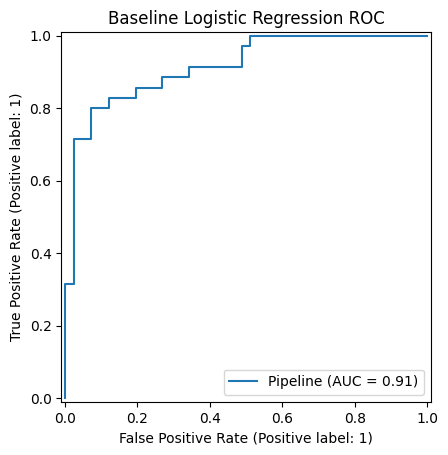

2026/01/06 09:48:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [7]:
with mlflow.start_run(run_name="Baseline_LogisticRegression"):

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000))
    ])

    model.fit(X_train, y_train)
    metrics = compute_metrics(model, X_test, y_test)

    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_metrics(metrics)
    mlflow.log_param("dataset_path", "/data/processed/cleaned_v0.csv")

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title("Baseline Logistic Regression ROC")
    plt.show()
    plt.savefig("metrics/lr_baseline_roc.png", bbox_inches="tight")
    mlflow.log_artifact("metrics/lr_baseline_roc.png")
    plt.close()

    mlflow.sklearn.log_model(model, "model")


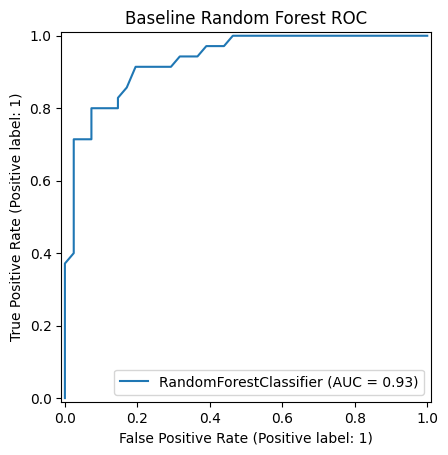

2026/01/06 09:48:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [8]:
with mlflow.start_run(run_name="Baseline_RandomForest"):

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    metrics = compute_metrics(model, X_test, y_test)

    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metrics(metrics)
    mlflow.log_param("dataset_path", "/data/processed/cleaned_v0.csv")
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title("Baseline Random Forest ROC")
    plt.show()
    plt.savefig("metrics/rf_baseline_roc.png", bbox_inches="tight")
    mlflow.log_artifact("metrics/rf_baseline_roc.png")
    plt.close()

    mlflow.sklearn.log_model(model, "model")


In [11]:
lr_param_grid = {
    "C": [0.01, 0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

with mlflow.start_run(run_name="LogisticRegression_Hyperparameter_Search"):

    for params in ParameterGrid(lr_param_grid):

        with mlflow.start_run(
            run_name=f"LR_C_{params['C']}",
            nested=True
        ):

            model = Pipeline([
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(
                    C=params["C"],
                    max_iter=1000
                ))
            ])

            cv_results = cross_validate(
                model, X, y,
                cv=cv,
                scoring=["accuracy", "precision", "recall", "roc_auc"]
            )

            mlflow.log_param("model", "LogisticRegression")
            mlflow.log_param("C", params["C"])

            for metric_name, values in cv_results.items():
                if metric_name.startswith("test_"):
                    mlflow.log_metric(
                        metric_name.replace("test_", ""),
                        np.mean(values)
                    )


In [12]:
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10]
}

with mlflow.start_run(run_name="RandomForest_Hyperparameter_Search"):

    for params in ParameterGrid(rf_param_grid):

        run_name = f"RF_n{params['n_estimators']}_d{params['max_depth']}"

        with mlflow.start_run(run_name=run_name, nested=True):

            model = RandomForestClassifier(
                n_estimators=params["n_estimators"],
                max_depth=params["max_depth"],
                random_state=42,
                n_jobs=-1
            )

            cv_results = cross_validate(
                model,
                X, y,
                cv=cv,
                scoring=["accuracy", "precision", "recall", "roc_auc"]
            )

            mlflow.log_param("model", "RandomForest")
            mlflow.log_param("n_estimators", params["n_estimators"])
            mlflow.log_param("max_depth", params["max_depth"])


            for metric_name, values in cv_results.items():
                if metric_name.startswith("test_"):
                    mlflow.log_metric(
                        metric_name.replace("test_", ""),
                        np.mean(values)
                    )


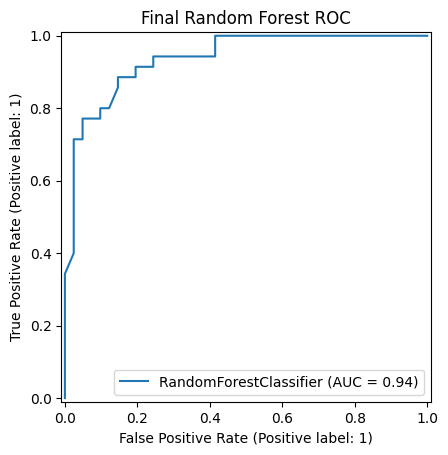

2026/01/06 10:17:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [13]:
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

with mlflow.start_run(run_name="Final_RandomForest"):

    best_rf.fit(X_train, y_train)
    metrics = compute_metrics(best_rf, X_test, y_test)

    mlflow.log_param("model", "RandomForest_Final")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 10)
    mlflow.log_metrics(metrics)

    RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
    plt.title("Final Random Forest ROC")
    plt.show()
    plt.savefig("metrics/rf_final_roc.png", bbox_inches="tight")
    mlflow.log_artifact("metrics/rf_final_roc.png")
    plt.close()

    mlflow.sklearn.log_model(best_rf, "model")


In [25]:
metrics

{'accuracy': 0.8421052631578947,
 'precision': 0.7948717948717948,
 'recall': 0.8857142857142857,
 'roc_auc': 0.937979094076655}

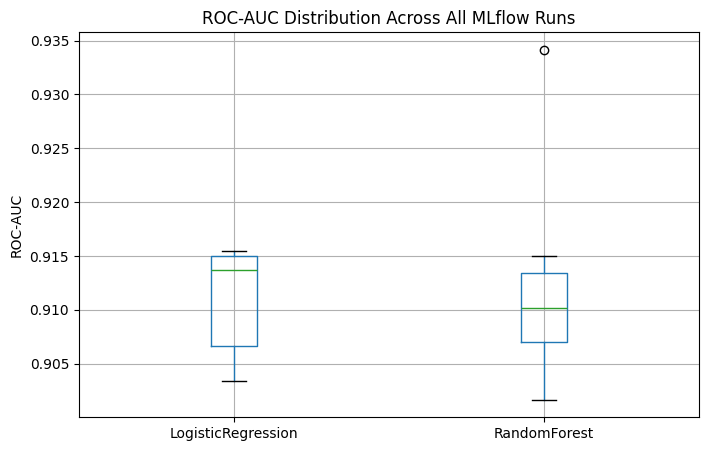

In [21]:
# Fetch all MLflow runs
runs_df = mlflow.search_runs()

lr_scores = runs_df.loc[
    runs_df["params.model"] == "LogisticRegression",
    "metrics.roc_auc"
]

rf_scores = runs_df.loc[
    runs_df["params.model"] == "RandomForest",
    "metrics.roc_auc"
]

cv_summary = pd.concat(
    [lr_scores.reset_index(drop=True),
     rf_scores.reset_index(drop=True)],
    axis=1
)

cv_summary.columns = ["LogisticRegression", "RandomForest"]

# Plot
plt.figure(figsize=(8, 5))
cv_summary.boxplot()
plt.title("ROC-AUC Distribution Across All MLflow Runs")
plt.ylabel("ROC-AUC")
plt.grid(True)
plt.show()

# Save & log to MLflow
plt.savefig("metrics/cv_all_runs_comparison.png")
mlflow.log_artifact("metrics/cv_all_runs_comparison.png")
plt.close()

In [24]:
#  Model Packaging

MODEL_DIR = Path("../models/latest")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
model_path = MODEL_DIR / "random_forest_best_v0.pkl"

with open(model_path, "wb") as f:
    pickle.dump(best_rf, f)

In [28]:

params = {
    "n_estimators": 200,
    "max_depth": 10
}

metadata = {**metrics, **params}
metadata

{'accuracy': 0.8421052631578947,
 'precision': 0.7948717948717948,
 'recall': 0.8857142857142857,
 'roc_auc': 0.937979094076655,
 'n_estimators': 200,
 'max_depth': 10}

In [29]:
with open( "../models/latest/metadata_v0.txt", "w") as f:
    for k, v in metadata.items():
        f.write(f"{k}: {v}\n")